# Ensemble Methods - Configurable & Extensible Design

This notebook demonstrates a highly configurable and extensible implementation of ensemble methods with flexible parameter management and strategy patterns.

## Key Features:
- **Configuration-Driven**: All parameters managed through configuration classes
- **Strategy Pattern**: Flexible parameter grid strategies
- **Separation of Concerns**: Model creation and parameter management are separated
- **Runtime Flexibility**: Parameters can be modified at runtime
- **Extensible Architecture**: Easy to add new models, strategies, and configurations
- **Production Ready**: Robust error handling and comprehensive logging

## Module Separation Strategy

When converting this notebook to Python files, the following modular structure is recommended:

```
ensemble_ml/
├── __init__.py
├── config/
│   ├── __init__.py
│   ├── base.py          # ExperimentConfig, ModelConfig, ModelResult
│   └── strategies.py    # ParameterStrategy and implementations
├── models/
│   ├── __init__.py
│   ├── base.py          # BaseEnsembleModel
│   ├── voting.py        # VotingEnsemble
│   ├── bagging.py       # RandomForestEnsemble
│   ├── stacking.py      # StackingEnsemble
│   └── boosting.py      # AdaBoost, XGBoost, LightGBM
├── factory/
│   ├── __init__.py
│   └── model_factory.py # ModelFactory
├── data/
│   ├── __init__.py
│   └── manager.py       # DataManager
├── analysis/
│   ├── __init__.py
│   └── results.py       # ResultsAnalyzer
└── pipeline/
    ├── __init__.py
    └── ensemble.py      # ConfigurableEnsemblePipeline
```

### Module Separation Benefits:
1. **Single Responsibility**: Each module has a clear, focused purpose
2. **Extensibility**: Easy to add new models, strategies, and configurations
3. **Maintainability**: Independent modification of each component
4. **Testability**: Each module can be tested independently
5. **Reusability**: Import only the modules you need

### Cell Organization:
Each cell in this notebook represents a logical module that would become a separate file in the production version.


In [2]:
# Standard library imports
import logging
import warnings
from abc import ABC, abstractmethod
from dataclasses import dataclass, field
from pathlib import Path
from typing import Any, Dict, List, Optional, Tuple, Union

# Third-party imports
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from lightgbm import LGBMClassifier
from sklearn.datasets import load_breast_cancer
from sklearn.ensemble import (
    AdaBoostClassifier,
    GradientBoostingClassifier,
    RandomForestClassifier,
    StackingClassifier,
    VotingClassifier,
)
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    ConfusionMatrixDisplay,
    f1_score,
    precision_score,
    recall_score,
    roc_auc_score,
)
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier

# Configuration
warnings.filterwarnings("ignore")
pd.set_option("display.max_columns", 100)
pd.set_option("display.max_rows", 100)
pd.set_option("float_format", "{:.4f}".format)

# Set up logging
logging.basicConfig(
    level=logging.INFO, format="%(asctime)s - %(name)s - %(levelname)s - %(message)s"
)
logger = logging.getLogger(__name__)

## Module 1: Configuration Management
*This would become `config/base.py` in the production version*


In [3]:
@dataclass
class ExperimentConfig:
    """Main configuration for ensemble experiments."""

    # Data settings
    dataset_name: str = "breast_cancer"
    test_size: float = 0.2
    random_state: int = 42

    # Cross-validation settings
    cv_folds: int = 5
    scoring: str = "accuracy"
    n_jobs: int = -1

    # Model settings
    verbose: int = 1

    # Output settings
    save_results: bool = True
    output_dir: str = "results"

    def __post_init__(self):
        """Create output directory if it doesn't exist."""
        if self.save_results:
            Path(self.output_dir).mkdir(exist_ok=True)


@dataclass
class ModelConfig:
    """Configuration for individual models."""

    model_type: str
    param_grid: Dict[str, List[Any]]
    model_kwargs: Dict[str, Any] = field(default_factory=dict)
    enabled: bool = True

    def __post_init__(self):
        """Validate model configuration."""
        if not self.model_type:
            raise ValueError("model_type cannot be empty")
        if not self.param_grid:
            raise ValueError("param_grid cannot be empty")


@dataclass
class ModelResult:
    """Data class to store model evaluation results."""

    model_name: str
    model: Any
    train_score: float
    test_score: float
    predictions: np.ndarray
    best_params: Dict[str, Any]
    cv_score: float
    training_time: float = 0.0

    @property
    def score_difference(self) -> float:
        """Calculate the difference between train and test scores."""
        return abs(self.train_score - self.test_score)

    @property
    def is_overfitting(self) -> bool:
        """Check if model is overfitting."""
        return self.score_difference > 0.05  # 5% threshold

    def to_dict(self) -> Dict[str, Any]:
        """Convert to dictionary for easy serialization."""
        return {
            "model_name": self.model_name,
            "train_score": self.train_score,
            "test_score": self.test_score,
            "score_difference": self.score_difference,
            "cv_score": self.cv_score,
            "is_overfitting": self.is_overfitting,
            "training_time": self.training_time,
            "best_params": self.best_params,
        }


# Global configuration
experiment_config = ExperimentConfig()
logger.info(f"Experiment configuration initialized: {experiment_config}")

2025-09-08 13:47:58,114 - __main__ - INFO - Experiment configuration initialized: ExperimentConfig(dataset_name='breast_cancer', test_size=0.2, random_state=42, cv_folds=5, scoring='accuracy', n_jobs=-1, verbose=1, save_results=True, output_dir='results')


## Module 2: Parameter Strategy Pattern
*This would become `config/strategies.py` in the production version*


In [4]:
class ParameterStrategy(ABC):
    """Abstract base class for parameter grid strategies."""

    @abstractmethod
    def get_param_grid(self, model_type: str) -> Dict[str, List[Any]]:
        """Get parameter grid for a specific model type."""
        pass


class ConservativeStrategy(ParameterStrategy):
    """Conservative parameter strategy with narrow ranges."""

    def get_param_grid(self, model_type: str) -> Dict[str, List[Any]]:
        """Get conservative parameter grid."""
        grids = {
            "voting": {
                "voting": ["hard"],
                "lr__C": [1.0],
                "dt__max_depth": [5],
                "knn__n_neighbors": [5],
            },
            "random_forest": {
                "n_estimators": [100],
                "max_depth": [5],
                "min_samples_split": [2],
            },
            "stacking": {
                "lr__C": [1.0],
                "dt__max_depth": [5],
                "final_estimator__C": [1.0],
            },
            "adaboost": {
                "n_estimators": [100],
                "learning_rate": [0.1],
            },
            "xgboost": {
                "n_estimators": [100],
                "max_depth": [5],
                "learning_rate": [0.1],
            },
            "lightgbm": {
                "n_estimators": [100],
                "max_depth": [5],
                "learning_rate": [0.1],
            },
        }
        return grids.get(model_type, {})


class StandardStrategy(ParameterStrategy):
    """Standard parameter strategy with moderate ranges."""

    def get_param_grid(self, model_type: str) -> Dict[str, List[Any]]:
        """Get standard parameter grid."""
        grids = {
            "voting": {
                "voting": ["hard", "soft"],
                "lr__C": [0.1, 1.0, 10.0],
                "dt__max_depth": [3, 5, 10, None],
                "dt__min_samples_split": [2, 5, 10],
                "knn__n_neighbors": [3, 5, 7, 9],
                "knn__weights": ["uniform", "distance"],
            },
            "random_forest": {
                "n_estimators": [50, 100, 200],
                "max_depth": [3, 5, 10, None],
                "min_samples_split": [2, 5, 10],
                "min_samples_leaf": [1, 2, 4],
                "max_features": ["sqrt", "log2", None],
                "bootstrap": [True, False],
            },
            "stacking": {
                "lr__C": [0.1, 1.0, 10.0],
                "dt__max_depth": [3, 5, 10],
                "dt__min_samples_split": [2, 5],
                "rf__max_depth": [3, 5, 10],
                "rf__min_samples_split": [2, 5],
                "final_estimator__C": [0.1, 1.0, 10.0],
            },
            "adaboost": {
                "n_estimators": [50, 100, 200],
                "learning_rate": [0.01, 0.1, 0.5, 1.0],
            },
            "xgboost": {
                "n_estimators": [50, 100, 200],
                "max_depth": [3, 5, 7],
                "learning_rate": [0.01, 0.1, 0.2],
                "subsample": [0.8, 0.9, 1.0],
            },
            "lightgbm": {
                "n_estimators": [50, 100, 200],
                "max_depth": [3, 5, 7],
                "learning_rate": [0.01, 0.1, 0.2],
                "num_leaves": [31, 50, 100],
            },
        }
        return grids.get(model_type, {})


class AggressiveStrategy(ParameterStrategy):
    """Aggressive parameter strategy with wide ranges."""

    def get_param_grid(self, model_type: str) -> Dict[str, List[Any]]:
        """Get aggressive parameter grid."""
        grids = {
            "voting": {
                "voting": ["hard", "soft"],
                "lr__C": [0.01, 0.1, 1.0, 10.0, 100.0],
                "dt__max_depth": [1, 3, 5, 10, 15, 20, None],
                "dt__min_samples_split": [2, 5, 10, 20],
                "dt__min_samples_leaf": [1, 2, 4, 8],
                "knn__n_neighbors": [1, 3, 5, 7, 9, 11, 15],
                "knn__weights": ["uniform", "distance"],
                "knn__metric": ["euclidean", "manhattan", "minkowski"],
            },
            "random_forest": {
                "n_estimators": [10, 50, 100, 200, 500],
                "max_depth": [1, 3, 5, 10, 15, 20, None],
                "min_samples_split": [2, 5, 10, 20, 50],
                "min_samples_leaf": [1, 2, 4, 8, 16],
                "max_features": ["sqrt", "log2", None, 0.5, 0.8],
                "bootstrap": [True, False],
                "criterion": ["gini", "entropy"],
            },
            "stacking": {
                "lr__C": [0.001, 0.01, 0.1, 1.0, 10.0, 100.0],
                "dt__max_depth": [1, 3, 5, 10, 15, None],
                "dt__min_samples_split": [2, 5, 10, 20],
                "rf__max_depth": [1, 3, 5, 10, 15, None],
                "rf__min_samples_split": [2, 5, 10, 20],
                "final_estimator__C": [0.001, 0.01, 0.1, 1.0, 10.0, 100.0],
            },
            "adaboost": {
                "n_estimators": [10, 50, 100, 200, 500],
                "learning_rate": [0.001, 0.01, 0.1, 0.5, 1.0, 2.0],
            },
            "xgboost": {
                "n_estimators": [10, 50, 100, 200, 500],
                "max_depth": [1, 3, 5, 7, 10],
                "learning_rate": [0.001, 0.01, 0.1, 0.2, 0.5],
                "subsample": [0.5, 0.8, 0.9, 1.0],
                "colsample_bytree": [0.5, 0.8, 0.9, 1.0],
            },
            "lightgbm": {
                "n_estimators": [10, 50, 100, 200, 500],
                "max_depth": [1, 3, 5, 7, 10],
                "learning_rate": [0.001, 0.01, 0.1, 0.2, 0.5],
                "num_leaves": [10, 31, 50, 100, 200],
                "subsample": [0.5, 0.8, 0.9, 1.0],
            },
        }
        return grids.get(model_type, {})


class CustomStrategy(ParameterStrategy):
    """Custom parameter strategy that allows manual specification."""

    def __init__(self, custom_grids: Dict[str, Dict[str, List[Any]]]):
        self.custom_grids = custom_grids

    def get_param_grid(self, model_type: str) -> Dict[str, List[Any]]:
        """Get custom parameter grid."""
        return self.custom_grids.get(model_type, {})

## Module 3: Model Classes (Parameter Grid Separated)
*This would become `models/base.py` and individual model files in the production version*


In [5]:
class BaseEnsembleModel(ABC):
    """Abstract base class for ensemble models."""

    def __init__(self, name: str, config: ExperimentConfig, model_config: ModelConfig):
        self.name = name
        self.config = config
        self.model_config = model_config
        self.model = None
        self.grid_search = None

    @abstractmethod
    def create_model(self) -> Any:
        """Create the base model."""
        pass

    def fit(self, X_train: np.ndarray, y_train: np.ndarray) -> ModelResult:
        """Fit the model with grid search."""
        import time

        start_time = time.time()

        logger.info(f"Starting Grid Search for {self.name}...")

        # Create model
        self.model = self.create_model()

        # Perform grid search
        self.grid_search = GridSearchCV(
            estimator=self.model,
            param_grid=self.model_config.param_grid,
            cv=self.config.cv_folds,
            scoring=self.config.scoring,
            n_jobs=self.config.n_jobs,
            verbose=self.config.verbose,
        )

        self.grid_search.fit(X_train, y_train)

        training_time = time.time() - start_time

        logger.info(f"{self.name} Grid Search completed in {training_time:.2f}s")
        logger.info(f"Best parameters: {self.grid_search.best_params_}")
        logger.info(f"Best CV score: {self.grid_search.best_score_:.4f}")

        return ModelResult(
            model_name=self.name,
            model=self.grid_search.best_estimator_,
            train_score=self.grid_search.best_estimator_.score(X_train, y_train),
            test_score=0.0,  # Will be set after evaluation
            predictions=np.array([]),  # Will be set after evaluation
            best_params=self.grid_search.best_params_,
            cv_score=self.grid_search.best_score_,
            training_time=training_time,
        )

    def evaluate(
        self, X_test: np.ndarray, y_test: np.ndarray, result: ModelResult
    ) -> ModelResult:
        """Evaluate the model on test set."""
        predictions = result.model.predict(X_test)
        test_score = result.model.score(X_test, y_test)

        # Update result
        result.test_score = test_score
        result.predictions = predictions

        logger.info(f"{self.name} Test Score: {test_score:.4f}")
        logger.info(f"{self.name} Score Difference: {result.score_difference:.4f}")

        return result


class VotingEnsemble(BaseEnsembleModel):
    """Voting Classifier implementation."""

    def create_model(self) -> VotingClassifier:
        base_estimators = [
            ("lr", LogisticRegression(random_state=self.config.random_state)),
            ("dt", DecisionTreeClassifier(random_state=self.config.random_state)),
            ("knn", KNeighborsClassifier()),
        ]
        return VotingClassifier(estimators=base_estimators)


class RandomForestEnsemble(BaseEnsembleModel):
    """Random Forest implementation."""

    def create_model(self) -> RandomForestClassifier:
        return RandomForestClassifier(random_state=self.config.random_state)


class StackingEnsemble(BaseEnsembleModel):
    """Stacking Classifier implementation."""

    def create_model(self) -> StackingClassifier:
        base_estimators = [
            ("lr", LogisticRegression(random_state=self.config.random_state)),
            ("dt", DecisionTreeClassifier(random_state=self.config.random_state)),
            (
                "rf",
                RandomForestClassifier(
                    random_state=self.config.random_state, n_estimators=50
                ),
            ),
        ]
        meta_estimator = LogisticRegression(random_state=self.config.random_state)

        return StackingClassifier(
            estimators=base_estimators,
            final_estimator=meta_estimator,
            cv=self.config.cv_folds,
        )


class AdaBoostEnsemble(BaseEnsembleModel):
    """AdaBoost implementation."""

    def create_model(self) -> AdaBoostClassifier:
        return AdaBoostClassifier(
            random_state=self.config.random_state, algorithm="SAMME"
        )


class XGBoostEnsemble(BaseEnsembleModel):
    """XGBoost implementation."""

    def create_model(self) -> XGBClassifier:
        return XGBClassifier(
            random_state=self.config.random_state, eval_metric="logloss"
        )


class LightGBMEnsemble(BaseEnsembleModel):
    """LightGBM implementation."""

    def create_model(self) -> LGBMClassifier:
        return LGBMClassifier(random_state=self.config.random_state, verbose=-1)

## Module 4: Enhanced Factory with Strategy Support
*This would become `factory/model_factory.py` in the production version*


In [6]:
class ModelFactory:
    """Enhanced factory class for creating ensemble models with strategy support."""

    _models = {
        "voting": VotingEnsemble,
        "random_forest": RandomForestEnsemble,
        "stacking": StackingEnsemble,
        "adaboost": AdaBoostEnsemble,
        "xgboost": XGBoostEnsemble,
        "lightgbm": LightGBMEnsemble,
    }

    @classmethod
    def create_model(
        self,
        model_type: str,
        config: ExperimentConfig,
        strategy: Optional[ParameterStrategy] = None,
        custom_model_config: Optional[ModelConfig] = None,
    ) -> BaseEnsembleModel:
        """Create an ensemble model instance with parameter strategy."""
        if model_type not in self._models:
            available_models = list(self._models.keys())
            raise ValueError(
                f"Unknown model type: {model_type}. Available: {available_models}"
            )

        # Create model configuration
        if custom_model_config:
            model_config = custom_model_config
        elif strategy:
            param_grid = strategy.get_param_grid(model_type)
            model_config = ModelConfig(model_type=model_type, param_grid=param_grid)
        else:
            # Use standard strategy as default
            standard_strategy = StandardStrategy()
            param_grid = standard_strategy.get_param_grid(model_type)
            model_config = ModelConfig(model_type=model_type, param_grid=param_grid)

        # Create model instance
        model_class = self._models[model_type]
        return model_class(model_type, config, model_config)

    @classmethod
    def create_models_with_strategy(
        cls,
        model_types: List[str],
        config: ExperimentConfig,
        strategy: ParameterStrategy,
    ) -> List[BaseEnsembleModel]:
        """Create multiple models with the same strategy."""
        models = []
        for model_type in model_types:
            try:
                model = cls.create_model(model_type, config, strategy)
                models.append(model)
            except Exception as e:
                logger.warning(f"Failed to create {model_type}: {str(e)}")
                continue
        return models

    @classmethod
    def create_models_with_custom_configs(
        cls, model_configs: List[ModelConfig], config: ExperimentConfig
    ) -> List[BaseEnsembleModel]:
        """Create models with custom configurations."""
        models = []
        for model_config in model_configs:
            if not model_config.enabled:
                continue
            try:
                model = cls.create_model(
                    model_config.model_type, config, custom_model_config=model_config
                )
                models.append(model)
            except Exception as e:
                logger.warning(f"Failed to create {model_config.model_type}: {str(e)}")
                continue
        return models

    @classmethod
    def get_available_models(cls) -> List[str]:
        """Get list of available model types."""
        return list(cls._models.keys())

    @classmethod
    def create_all_models_with_strategy(
        cls, config: ExperimentConfig, strategy: ParameterStrategy
    ) -> List[BaseEnsembleModel]:
        """Create all available models with a specific strategy."""
        return cls.create_models_with_strategy(
            cls.get_available_models(), config, strategy
        )

## Module 5: Data Management
*This would become `data/manager.py` in the production version*


In [7]:
class DataManager:
    """Handles data loading, preprocessing, and splitting."""

    def __init__(self, config: ExperimentConfig):
        self.config = config
        self.scaler = StandardScaler()
        self.feature_names: Optional[List[str]] = None
        self.target_names: Optional[List[str]] = None

    def load_data(self) -> Tuple[pd.DataFrame, np.ndarray, List[str], List[str]]:
        """Load and return the dataset."""
        logger.info(f"Loading {self.config.dataset_name} dataset...")

        if self.config.dataset_name == "breast_cancer":
            data = load_breast_cancer()
            X = data.data
            y = data.target
            self.feature_names = list(data.feature_names)
            self.target_names = list(data.target_names)
        else:
            raise ValueError(f"Unsupported dataset: {self.config.dataset_name}")

        # Create DataFrame
        df = pd.DataFrame(X, columns=self.feature_names)
        df["target"] = y

        logger.info(f"Dataset loaded: {df.shape[0]} samples, {df.shape[1]-1} features")
        logger.info(f"Target distribution: {np.bincount(y)}")

        return df, y, self.feature_names, self.target_names

    def preprocess_data(self, df: pd.DataFrame) -> pd.DataFrame:
        """Preprocess the data (scaling, etc.)."""
        logger.info("Preprocessing data...")

        # Separate features and target
        X = df.drop(["target"], axis=1)
        y = df["target"]

        # Scale features
        X_scaled = self.scaler.fit_transform(X)
        df_scaled = pd.DataFrame(X_scaled, columns=self.feature_names)
        df_scaled["target"] = y

        logger.info("Data preprocessing completed")
        return df_scaled

    def split_data(
        self, df: pd.DataFrame
    ) -> Tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray]:
        """Split data into train and test sets."""
        logger.info("Splitting data into train and test sets...")

        X = df.drop(["target"], axis=1)
        y = df["target"]

        X_train, X_test, y_train, y_test = train_test_split(
            X,
            y,
            test_size=self.config.test_size,
            random_state=self.config.random_state,
            stratify=y,
        )

        logger.info(f"Train set: {X_train.shape}")
        logger.info(f"Test set: {X_test.shape}")
        logger.info(f"Train target distribution: {np.bincount(y_train)}")
        logger.info(f"Test target distribution: {np.bincount(y_test)}")

        return X_train, X_test, y_train, y_test

## Module 6: Results Analysis
*This would become `analysis/results.py` in the production version*


In [8]:
class ResultsAnalyzer:
    """Handles results analysis and visualization."""

    def __init__(self, config: ExperimentConfig):
        self.config = config
        self.results: List[ModelResult] = []

    def add_result(self, result: ModelResult) -> None:
        """Add a model result to the analyzer."""
        self.results.append(result)

    def get_results_dataframe(self) -> pd.DataFrame:
        """Convert results to DataFrame for analysis."""
        if not self.results:
            return pd.DataFrame()

        data = [result.to_dict() for result in self.results]
        df = pd.DataFrame(data)

        # Sort by score difference (ascending), then by test score (descending)
        df = df.sort_values(
            by=["score_difference", "test_score"], ascending=[True, False]
        ).reset_index(drop=True)

        return df

    def plot_performance_comparison(self, figsize: Tuple[int, int] = (15, 6)) -> None:
        """Plot performance comparison charts."""
        if not self.results:
            logger.warning("No results to plot")
            return

        df = self.get_results_dataframe()

        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=figsize)

        # Train vs Test scores
        ax1.scatter(df["train_score"], df["test_score"], s=100, alpha=0.7)
        for i, row in df.iterrows():
            ax1.annotate(
                row["model_name"],
                (row["train_score"], row["test_score"]),
                xytext=(5, 5),
                textcoords="offset points",
                fontsize=8,
            )
        ax1.plot([0.9, 1.0], [0.9, 1.0], "r--", alpha=0.5, label="Perfect fit")
        ax1.set_xlabel("Train Score")
        ax1.set_ylabel("Test Score")
        ax1.set_title("Train vs Test Scores")
        ax1.legend()
        ax1.grid(True, alpha=0.3)

        # Score difference (overfitting analysis)
        colors = ["red" if overfit else "green" for overfit in df["is_overfitting"]]
        ax2.bar(range(len(df)), df["score_difference"], color=colors, alpha=0.7)
        ax2.set_xticks(range(len(df)))
        ax2.set_xticklabels(df["model_name"], rotation=45, ha="right")
        ax2.set_ylabel("Score Difference (|Train - Test|)")
        ax2.set_title("Overfitting Analysis")
        ax2.axhline(
            y=0.05,
            color="red",
            linestyle="--",
            alpha=0.5,
            label="Overfitting threshold",
        )
        ax2.legend()
        ax2.grid(True, alpha=0.3)

        plt.tight_layout()
        plt.show()

    def print_summary(self) -> None:
        """Print summary of all results."""
        if not self.results:
            logger.warning("No results to summarize")
            return

        df = self.get_results_dataframe()

        print("\n" + "=" * 60)
        print("ENSEMBLE MODELS PERFORMANCE SUMMARY")
        print("=" * 60)

        print(f"\nDataset: {self.config.dataset_name}")
        print(f"Cross-Validation: {self.config.cv_folds}-fold")
        print(f"Total Models: {len(self.results)}")

        print(f"\nBest Performing Model: {df.iloc[0]['model_name']}")
        print(f"  Test Score: {df.iloc[0]['test_score']:.4f}")
        print(f"  Score Difference: {df.iloc[0]['score_difference']:.4f}")
        print(f"  Training Time: {df.iloc[0]['training_time']:.2f}s")

        print(f"\nOverfitting Models: {df['is_overfitting'].sum()}/{len(df)}")

        print(f"\nDetailed Results:")
        print(
            df[
                ["model_name", "test_score", "score_difference", "training_time"]
            ].to_string(index=False)
        )

        print("\n" + "=" * 60)

    def save_results(self, filename: Optional[str] = None) -> None:
        """Save results to CSV file."""
        if not self.results:
            logger.warning("No results to save")
            return

        if filename is None:
            filename = f"ensemble_results_{self.config.dataset_name}.csv"

        filepath = Path(self.config.output_dir) / filename
        df = self.get_results_dataframe()
        df.to_csv(filepath, index=False)
        logger.info(f"Results saved to {filepath}")

## Module 7: Enhanced Pipeline with Strategy Support
*This would become `pipeline/ensemble.py` in the production version*


In [9]:
class ConfigurableEnsemblePipeline:
    """Enhanced pipeline for ensemble model training with strategy support."""

    def __init__(self, config: ExperimentConfig):
        self.config = config
        self.data_manager = DataManager(config)
        self.results_analyzer = ResultsAnalyzer(config)
        self.models: List[BaseEnsembleModel] = []

    def setup_models_with_strategy(
        self, model_types: List[str], strategy: ParameterStrategy
    ) -> None:
        """Setup models with a specific parameter strategy."""
        self.models = ModelFactory.create_models_with_strategy(
            model_types, self.config, strategy
        )
        logger.info(
            f"Setup {len(self.models)} models with {strategy.__class__.__name__} strategy"
        )

    def setup_models_with_custom_configs(
        self, model_configs: List[ModelConfig]
    ) -> None:
        """Setup models with custom configurations."""
        self.models = ModelFactory.create_models_with_custom_configs(
            model_configs, self.config
        )
        logger.info(f"Setup {len(self.models)} models with custom configurations")

    def run_experiment_with_strategy(
        self, model_types: List[str], strategy: ParameterStrategy
    ) -> None:
        """Run experiment with a specific parameter strategy."""
        try:
            # Setup models
            self.setup_models_with_strategy(model_types, strategy)

            # Load and preprocess data
            logger.info("Starting configurable ensemble experiment...")
            df, y, feature_names, target_names = self.data_manager.load_data()
            df_processed = self.data_manager.preprocess_data(df)
            X_train, X_test, y_train, y_test = self.data_manager.split_data(
                df_processed
            )

            # Train and evaluate models
            for model in self.models:
                try:
                    logger.info(
                        f"Processing {model.name} with {strategy.__class__.__name__} strategy..."
                    )

                    # Fit model
                    result = model.fit(X_train, y_train)

                    # Evaluate model
                    result = model.evaluate(X_test, y_test, result)

                    # Add to results
                    self.results_analyzer.add_result(result)

                    logger.info(f"Completed {model.name}")

                except Exception as e:
                    logger.error(f"Error processing {model.name}: {str(e)}")
                    continue

            # Analyze results
            self.results_analyzer.print_summary()

            # Save results
            if self.config.save_results:
                filename = f"ensemble_results_{strategy.__class__.__name__.lower()}.csv"
                self.results_analyzer.save_results(filename)

            logger.info("Configurable ensemble experiment completed successfully!")

        except Exception as e:
            logger.error(f"Error in configurable ensemble experiment: {str(e)}")
            raise

    def run_experiment_with_custom_configs(
        self, model_configs: List[ModelConfig]
    ) -> None:
        """Run experiment with custom model configurations."""
        try:
            # Setup models
            self.setup_models_with_custom_configs(model_configs)

            # Load and preprocess data
            logger.info("Starting custom configuration ensemble experiment...")
            df, y, feature_names, target_names = self.data_manager.load_data()
            df_processed = self.data_manager.preprocess_data(df)
            X_train, X_test, y_train, y_test = self.data_manager.split_data(
                df_processed
            )

            # Train and evaluate models
            for model in self.models:
                try:
                    logger.info(f"Processing {model.name} with custom configuration...")

                    # Fit model
                    result = model.fit(X_train, y_train)

                    # Evaluate model
                    result = model.evaluate(X_test, y_test, result)

                    # Add to results
                    self.results_analyzer.add_result(result)

                    logger.info(f"Completed {model.name}")

                except Exception as e:
                    logger.error(f"Error processing {model.name}: {str(e)}")
                    continue

            # Analyze results
            self.results_analyzer.print_summary()

            # Save results
            if self.config.save_results:
                self.results_analyzer.save_results("ensemble_results_custom.csv")

            logger.info(
                "Custom configuration ensemble experiment completed successfully!"
            )

        except Exception as e:
            logger.error(f"Error in custom configuration experiment: {str(e)}")
            raise

    def compare_strategies(
        self, model_types: List[str], strategies: List[ParameterStrategy]
    ) -> Dict[str, pd.DataFrame]:
        """Compare multiple parameter strategies."""
        results = {}

        for strategy in strategies:
            logger.info(
                f"Running experiment with {strategy.__class__.__name__} strategy..."
            )

            # Create new pipeline for each strategy
            pipeline = ConfigurableEnsemblePipeline(self.config)
            pipeline.run_experiment_with_strategy(model_types, strategy)

            # Store results
            strategy_name = strategy.__class__.__name__.lower()
            results[strategy_name] = pipeline.get_results()

        return results

    def get_results(self) -> pd.DataFrame:
        """Get results as DataFrame."""
        return self.results_analyzer.get_results_dataframe()

    def plot_results(self) -> None:
        """Plot all result visualizations."""
        self.results_analyzer.plot_performance_comparison()

    def get_best_model(self) -> Optional[ModelResult]:
        """Get the best performing model."""
        if not self.results_analyzer.results:
            return None

        df = self.results_analyzer.get_results_dataframe()
        best_model_name = df.iloc[0]["model_name"]
        return next(
            r for r in self.results_analyzer.results if r.model_name == best_model_name
        )

## Execution Example


2025-09-08 13:48:47,632 - __main__ - INFO - Setup 6 models with StandardStrategy strategy
2025-09-08 13:48:47,633 - __main__ - INFO - Starting configurable ensemble experiment...
2025-09-08 13:48:47,634 - __main__ - INFO - Loading breast_cancer dataset...
2025-09-08 13:48:47,646 - __main__ - INFO - Dataset loaded: 569 samples, 30 features
2025-09-08 13:48:47,647 - __main__ - INFO - Target distribution: [212 357]
2025-09-08 13:48:47,647 - __main__ - INFO - Preprocessing data...
2025-09-08 13:48:47,651 - __main__ - INFO - Data preprocessing completed
2025-09-08 13:48:47,652 - __main__ - INFO - Splitting data into train and test sets...
2025-09-08 13:48:47,654 - __main__ - INFO - Train set: (455, 30)
2025-09-08 13:48:47,654 - __main__ - INFO - Test set: (114, 30)
2025-09-08 13:48:47,655 - __main__ - INFO - Train target distribution: [170 285]
2025-09-08 13:48:47,655 - __main__ - INFO - Test target distribution: [42 72]
2025-09-08 13:48:47,656 - __main__ - INFO - Processing voting with Sta

ENSEMBLE METHODS - CONFIGURABLE DESIGN DEMONSTRATION

Running experiment with 6 models using StandardStrategy strategy...
Models: voting, random_forest, stacking, adaboost, xgboost, lightgbm
Fitting 5 folds for each of 576 candidates, totalling 2880 fits


2025-09-08 13:48:55,082 - __main__ - INFO - voting Grid Search completed in 7.43s
2025-09-08 13:48:55,085 - __main__ - INFO - Best parameters: {'dt__max_depth': 5, 'dt__min_samples_split': 2, 'knn__n_neighbors': 3, 'knn__weights': 'uniform', 'lr__C': 0.1, 'voting': 'hard'}
2025-09-08 13:48:55,099 - __main__ - INFO - Best CV score: 0.9780
2025-09-08 13:48:55,390 - __main__ - INFO - voting Test Score: 0.9825
2025-09-08 13:48:55,391 - __main__ - INFO - voting Score Difference: 0.0088
2025-09-08 13:48:55,391 - __main__ - INFO - Completed voting
2025-09-08 13:48:55,392 - __main__ - INFO - Processing random_forest with StandardStrategy strategy...
2025-09-08 13:48:55,393 - __main__ - INFO - Starting Grid Search for random_forest...


Fitting 5 folds for each of 648 candidates, totalling 3240 fits


2025-09-08 13:50:10,246 - __main__ - INFO - random_forest Grid Search completed in 74.85s
2025-09-08 13:50:10,247 - __main__ - INFO - Best parameters: {'bootstrap': False, 'max_depth': None, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
2025-09-08 13:50:10,247 - __main__ - INFO - Best CV score: 0.9692
2025-09-08 13:50:10,257 - __main__ - INFO - random_forest Test Score: 0.9561
2025-09-08 13:50:10,257 - __main__ - INFO - random_forest Score Difference: 0.0439
2025-09-08 13:50:10,257 - __main__ - INFO - Completed random_forest
2025-09-08 13:50:10,258 - __main__ - INFO - Processing stacking with StandardStrategy strategy...
2025-09-08 13:50:10,258 - __main__ - INFO - Starting Grid Search for stacking...


Fitting 5 folds for each of 324 candidates, totalling 1620 fits


2025-09-08 13:51:06,716 - __main__ - INFO - stacking Grid Search completed in 56.46s
2025-09-08 13:51:06,717 - __main__ - INFO - Best parameters: {'dt__max_depth': 5, 'dt__min_samples_split': 5, 'final_estimator__C': 10.0, 'lr__C': 1.0, 'rf__max_depth': 10, 'rf__min_samples_split': 2}
2025-09-08 13:51:06,717 - __main__ - INFO - Best CV score: 0.9824
2025-09-08 13:51:06,780 - __main__ - INFO - stacking Test Score: 0.9649
2025-09-08 13:51:06,784 - __main__ - INFO - stacking Score Difference: 0.0263
2025-09-08 13:51:06,786 - __main__ - INFO - Completed stacking
2025-09-08 13:51:06,789 - __main__ - INFO - Processing adaboost with StandardStrategy strategy...
2025-09-08 13:51:06,790 - __main__ - INFO - Starting Grid Search for adaboost...


Fitting 5 folds for each of 12 candidates, totalling 60 fits


2025-09-08 13:51:08,465 - __main__ - INFO - adaboost Grid Search completed in 1.67s
2025-09-08 13:51:08,465 - __main__ - INFO - Best parameters: {'learning_rate': 0.5, 'n_estimators': 100}
2025-09-08 13:51:08,465 - __main__ - INFO - Best CV score: 0.9780
2025-09-08 13:51:08,482 - __main__ - INFO - adaboost Test Score: 0.9561
2025-09-08 13:51:08,483 - __main__ - INFO - adaboost Score Difference: 0.0439
2025-09-08 13:51:08,483 - __main__ - INFO - Completed adaboost
2025-09-08 13:51:08,484 - __main__ - INFO - Processing xgboost with StandardStrategy strategy...
2025-09-08 13:51:08,484 - __main__ - INFO - Starting Grid Search for xgboost...


Fitting 5 folds for each of 81 candidates, totalling 405 fits


2025-09-08 13:51:11,705 - __main__ - INFO - xgboost Grid Search completed in 3.22s
2025-09-08 13:51:11,705 - __main__ - INFO - Best parameters: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 200, 'subsample': 0.9}
2025-09-08 13:51:11,705 - __main__ - INFO - Best CV score: 0.9802
2025-09-08 13:51:11,715 - __main__ - INFO - xgboost Test Score: 0.9561
2025-09-08 13:51:11,715 - __main__ - INFO - xgboost Score Difference: 0.0439
2025-09-08 13:51:11,715 - __main__ - INFO - Completed xgboost
2025-09-08 13:51:11,715 - __main__ - INFO - Processing lightgbm with StandardStrategy strategy...
2025-09-08 13:51:11,716 - __main__ - INFO - Starting Grid Search for lightgbm...


Fitting 5 folds for each of 81 candidates, totalling 405 fits


2025-09-08 13:51:59,863 - __main__ - INFO - lightgbm Grid Search completed in 48.15s
2025-09-08 13:51:59,863 - __main__ - INFO - Best parameters: {'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 200, 'num_leaves': 31}
2025-09-08 13:51:59,864 - __main__ - INFO - Best CV score: 0.9802
2025-09-08 13:51:59,869 - __main__ - INFO - lightgbm Test Score: 0.9649
2025-09-08 13:51:59,869 - __main__ - INFO - lightgbm Score Difference: 0.0351
2025-09-08 13:51:59,869 - __main__ - INFO - Completed lightgbm
2025-09-08 13:51:59,880 - __main__ - INFO - Results saved to results/ensemble_results_standardstrategy.csv
2025-09-08 13:51:59,881 - __main__ - INFO - Configurable ensemble experiment completed successfully!



ENSEMBLE MODELS PERFORMANCE SUMMARY

Dataset: breast_cancer
Cross-Validation: 5-fold
Total Models: 6

Best Performing Model: voting
  Test Score: 0.9825
  Score Difference: 0.0088
  Training Time: 7.43s

Overfitting Models: 0/6

Detailed Results:
   model_name  test_score  score_difference  training_time
       voting      0.9825            0.0088         7.4266
     stacking      0.9649            0.0263        56.4584
     lightgbm      0.9649            0.0351        48.1469
random_forest      0.9561            0.0439        74.8529
     adaboost      0.9561            0.0439         1.6744
      xgboost      0.9561            0.0439         3.2208


EXPERIMENT COMPLETED SUCCESSFULLY!

Final Results Summary:
   model_name  test_score  score_difference  training_time
       voting      0.9825            0.0088         7.4266
     stacking      0.9649            0.0263        56.4584
     lightgbm      0.9649            0.0351        48.1469
random_forest      0.9561            0.043

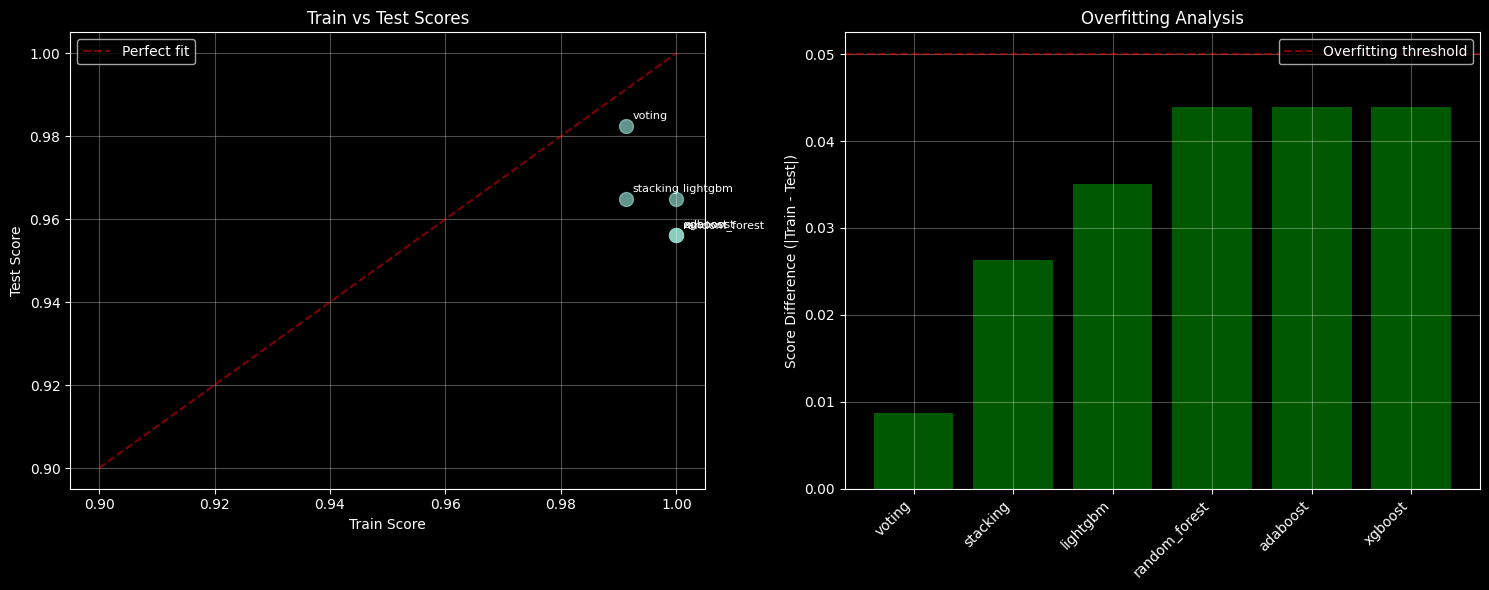


🏆 Best Performing Model: voting
   Test Score: 0.9825
   Score Difference: 0.0088
   Training Time: 7.43s
   Best Parameters: {'dt__max_depth': 5, 'dt__min_samples_split': 2, 'knn__n_neighbors': 3, 'knn__weights': 'uniform', 'lr__C': 0.1, 'voting': 'hard'}


In [10]:
# Complete Ensemble Experiment with Standard Strategy
print("=" * 60)
print("ENSEMBLE METHODS - CONFIGURABLE DESIGN DEMONSTRATION")
print("=" * 60)

# Initialize pipeline with experiment configuration
pipeline = ConfigurableEnsemblePipeline(experiment_config)

# Define models to test
model_types = ["voting", "random_forest", "stacking", "adaboost", "xgboost", "lightgbm"]

# Use standard parameter strategy
strategy = StandardStrategy()

print(
    f"\nRunning experiment with {len(model_types)} models using {strategy.__class__.__name__} strategy..."
)
print(f"Models: {', '.join(model_types)}")

# Run the complete experiment
pipeline.run_experiment_with_strategy(model_types, strategy)

# Display results
print("\n" + "=" * 60)
print("EXPERIMENT COMPLETED SUCCESSFULLY!")
print("=" * 60)

# Get and display results
results_df = pipeline.get_results()
print("\nFinal Results Summary:")
print(
    results_df[
        ["model_name", "test_score", "score_difference", "training_time"]
    ].to_string(index=False)
)

# Plot performance comparison
pipeline.plot_results()

# Get best model information
best_model = pipeline.get_best_model()
if best_model:
    print(f"\n🏆 Best Performing Model: {best_model.model_name}")
    print(f"   Test Score: {best_model.test_score:.4f}")
    print(f"   Score Difference: {best_model.score_difference:.4f}")
    print(f"   Training Time: {best_model.training_time:.2f}s")
    print(f"   Best Parameters: {best_model.best_params}")